# Qiskit Workshop: Error Mitigation and Suppression

Error mitigation and suppression are techniques to improve the results from calculations on a quantum computer with noise and errors. The Qiskit Runtime primitives, `Estimator` and `Sampler` have several mitigation and suppression algorithms built-in that can be activated with a simple option.

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options

import numpy as np

For this example, we will be using the the VQE algorithm and `Estimator` primitive to compute the expectation value of a given Hamiltonian operator.

First, define the Hamiltonian operator that encodes our problem to solve.

In [2]:
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

Instantiate the Qiskit Runtime. We'll use the QASM simulator on the IBM Quantum Platform.

In [3]:
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend('ibmq_qasm_simulator')

The simulator can be programmed to emulate the noise characteristics of a real quantum computer. In this case, we will use the noise model from the `ibmq_belem` computer.

In [4]:
from qiskit.providers.fake_provider import FakeBelem
from qiskit_aer.noise import NoiseModel

fake_noisy_backend = FakeBelem()
noise_model = NoiseModel.from_backend(fake_noisy_backend)

The noise model is applied to the Qiskit Runtime `Options` object.

We can also set two parameters that control the level of error mitigation and suppression:

- `options.optimization_level`: controls the suppression techniques used. `0` means no suppression.
- `options.resiliance_level`: controls the mitigation techniques used. `0` means no mitigation.

In [5]:
from qiskit_ibm_runtime import Options

options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_noisy_backend.configuration().basis_gates,
    "coupling_map": fake_noisy_backend.configuration().coupling_map,
    "seed_simulator": 42
}

options.execution.shots = 1024
options.optimization_level = 0
options.resiliance_level = 0

Create an ansatz circuit to generate the trial ground state

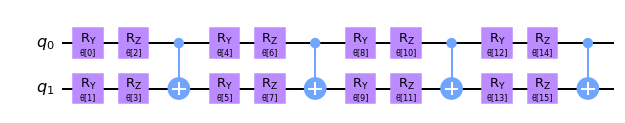

In [41]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=hamiltonian.num_qubits, reps=4, skip_final_rotation_layer=True, entanglement='linear')
ansatz.decompose().draw()

In [42]:
# Randomly initialize the circuit parameters

x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)

Define a cost function to evaluate in the VQE loop

In [7]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

Create a callback function to print out progress of the VQE loop and to record each iteration

In [8]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        value = estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        callback_dict["cost_history"].append(value)
        # Print to screen on single line
        print(
            "Iters. done: {} [value: {}]".format(callback_dict["iters"], value),
            end="\r",
            flush=True
        )

    return callback

## No Error Suppression or Mitigation

First, set up the callback function data structure

In [45]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": []
}

Now run the VQE algorithm by leveraging the `scipy.optimize` library.

In [46]:
# No error mititgation or suppression

from scipy.optimize import minimize

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    estimator = Estimator(session=session, options=options)
    callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
    result = minimize(cost_func, x0,  args=(ansatz, hamiltonian, estimator), method="cobyla", options={"maxiter": 300}, callback=callback)

print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.593571007824909
       x: [ 6.881e+00  5.992e+00 ...  6.703e+00  8.310e-01]
    nfev: 161
   maxcv: 0.0


## Use Error Mitigation and Suppression

Create a new data structure for the error mitigated results

In [47]:
callback_dict_mitigated = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": []
}

Now turn on error mitigation and suppression in the `Estimator` primitive via the `Options` object.

`optimization_level=3` is the highest suppression level, which implements dynamic decoupling.

`resiliance_level=2` implements the Zero-noise extrapolation method and the T-REx readout error mitigation method.

In [48]:
# With error mitigation and suppression

# Use Dynamic Decoupling
options.optimization_level = 3

# Use Zero-noise extrapolation and T-REx
options.resiliance_level = 2

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    estimator = Estimator(session=session, options=options)
    callback = build_callback(ansatz, hamiltonian, estimator, callback_dict_mitigated)
    result_mit = minimize(cost_func, x0,  args=(ansatz, hamiltonian, estimator), method="cobyla", options={"maxiter": 300}, callback=callback)

print(result_mit)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6367600150154892
       x: [ 5.594e+00  6.789e+00 ...  6.121e+00  1.039e+00]
    nfev: 151
   maxcv: 0.0


### Calculate in simulator as reference

In [43]:
callback_dict_sim = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": []
}

In [44]:
from qiskit.primitives import Estimator as EstimatorSim

estimator_sim = EstimatorSim()
callback = build_callback(ansatz, hamiltonian, estimator_sim, callback_dict_sim)
result_sim = minimize(cost_func, x0,  args=(ansatz, hamiltonian, estimator_sim), method="cobyla", options={"maxiter": 500}, callback=callback)
print(result_sim)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.702930384683139
       x: [ 6.862e+00  5.888e+00 ...  6.425e+00  9.947e-01]
    nfev: 288
   maxcv: 0.0


Let's see how the results from each of the different runs compare on the convergence graph.

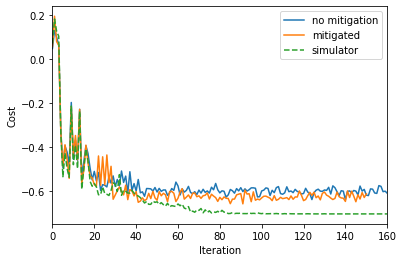

In [61]:
# Plot convergence of error mitigtation/suppression vs. no error mitgation/suppression

import matplotlib.pyplot as plt

plt.plot(callback_dict['cost_history'])
plt.plot(callback_dict_mitigated['cost_history'])
plt.plot(callback_dict_sim['cost_history'], linestyle='dashed')
plt.xlim(0, 160)
plt.xlabel("Iteration")
plt.ylabel('Cost')
plt.legend(['no mitigation', 'mitigated', 'simulator'])


In [1]:
import qiskit.tools.jupyter
%qiskit_version_table